In [2]:
import tensorflow as tf
import numpy as np
from matplotlib.pyplot import imshow, imsave, imread
from tensorflow.python.platform import gfile

Combining the facenet implementation (https://github.com/davidsandberg/facenet) with the Neural-Style-Transfer implementation (taken from CNN course on Coursera, week 4 https://www.coursera.org/learn/convolutional-neural-networks).

In [3]:
WIDTH = 160 # changing will require training a new embedding model from scratch
HEIGHT = 160 
CHANNELS = 3

In [4]:
# load frozen protobuf
graph_def = tf.GraphDef()
with gfile.FastGFile('./models/20180402-114759.pb','rb') as f:
    graph_def.ParseFromString(f.read())

# frozen models turn all variables to constants, which is good for us
# replace input tensor as a variable
input_var = tf.Variable(initial_value=np.zeros((1, WIDTH, HEIGHT, CHANNELS)), dtype = 'float32')

# load frozen facenet model (to the default graph)
tf.import_graph_def(graph_def, input_map={"input:0": input_var}, name='mg')

In [5]:
# extract the interesting layers

# train phase - if to use batch normalization - for our purposes this should (probably) be set to false
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("mg/phase_train:0")

# embedding - final layer of the facenet model - a 512d vector representation of the input image
embeddings = tf.get_default_graph().get_tensor_by_name("mg/embeddings:0")

# some other layers, going from end to start 
mixed_7a = tf.get_default_graph().get_tensor_by_name("mg/InceptionResnetV1/Mixed_7a/Branch_0/Conv2d_1a_3x3/Relu:0")
mixed_6a = tf.get_default_graph().get_tensor_by_name("mg/InceptionResnetV1/Mixed_6a/Branch_0/Conv2d_1a_3x3/Relu:0")
conv_4b = tf.get_default_graph().get_tensor_by_name("mg/InceptionResnetV1/Conv2d_4b_3x3/Relu:0")
conv_4a = tf.get_default_graph().get_tensor_by_name("mg/InceptionResnetV1/Conv2d_4a_3x3/Relu:0")
conv_3b = tf.get_default_graph().get_tensor_by_name("mg/InceptionResnetV1/Conv2d_3b_1x1/Relu:0")
conv_2b = tf.get_default_graph().get_tensor_by_name("mg/InceptionResnetV1/Conv2d_2b_3x3/Relu:0")
conv_2a = tf.get_default_graph().get_tensor_by_name("mg/InceptionResnetV1/Conv2d_2a_3x3/Relu:0")
conv_1a = tf.get_default_graph().get_tensor_by_name("mg/InceptionResnetV1/Conv2d_1a_3x3/Relu:0")

In [6]:
coef_layers = [
    (.14, mixed_7a),
    (.14, mixed_6a),
    (.12, conv_4b),
    (0.12, conv_4a),
    (0.12, conv_3b),
    (0.12, conv_2b),
    (0.12, conv_2a),
    (0.12, conv_1a),
]

Let's compute the costs functions

In [7]:
# We can try to make sure the embedding doesn't get too far from the original picture, 
# but it might be too far away from the pipeline. NST guys took a more middle layer
def compute_embedding_cost(layer, image):
    # control for original image
    sess.run(input_var.assign(image))
    out = sess.run(layer, feed_dict={phase_train_placeholder:False })    
    J_content = tf.reduce_mean(tf.square(out - layer))/2
    return J_content

In [8]:
# we can try to control in another layer
def compute_content_cost(layer, image):
    sess.run(input_var.assign(image))
    out = sess.run(layer, feed_dict={phase_train_placeholder:False })
    content_cost = tf.reduce_mean(tf.square(layer - out))/2
    return content_cost

In [9]:
def compute_layer_style_cost(a_S, a_G):
    # Retrieve dimensions 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W)
    a_S = tf.transpose(tf.reshape(a_S, (n_H*n_W, n_C)))
    a_G = tf.transpose(tf.reshape(a_G, (n_H*n_W, n_C)))

    # Computing gram_matrices for both images S and G
    GS =  tf.matmul(a_S, tf.transpose(a_S))
    GG =  tf.matmul(a_G, tf.transpose(a_G))

    # Computing the loss
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4*((n_H*n_W)**2)*(n_C**2))
        
    return J_style_layer

In [10]:
def compute_target_style_cost(coef_layers, image):
    # initialize the overall style cost
    J_style = 0

    for coeff, layer in coef_layers:
        # Set a_S to be the hidden layer activation from the layer we have selected
        sess.run(input_var.assign(image))
        a_S = sess.run(layer, feed_dict={phase_train_placeholder:False })

        # Set a_G to be the hidden layer activation from same layer
        a_G = layer

        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer
    return J_style

Load the images

In [11]:
# target image - me
Target = imread('./David2.png')[:,:,:3]
Target = Target.reshape(1, WIDTH, HEIGHT, CHANNELS)

In [12]:
# original image - Isabell H - note this was done with a few other images before 
Origin = imread('./Isabell2.png')[:,:,:3]
Origin = Origin.reshape(1, WIDTH, HEIGHT, CHANNELS)

In [13]:
def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y  

In [14]:
# Target = prewhiten(Target)  - doesn't seem to improve anything
# Origin = prewhiten(Origin)

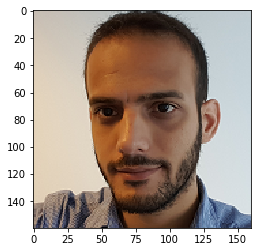

In [15]:
imshow(Target[0])

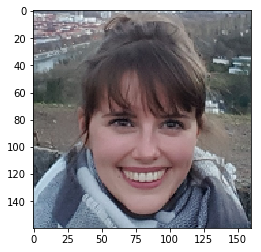

In [16]:
imshow(Origin[0])

Start session

In [17]:
sess = tf.InteractiveSession()
init_global = tf.global_variables_initializer()
sess.run(init_global)

In [18]:
# define cost function
J_original = compute_embedding_cost(embeddings, Origin)/2 + compute_content_cost(mixed_6a, Origin)/2
J_target = compute_embedding_cost(embeddings, Target)/2 + compute_target_style_cost(coef_layers, Target)/2
J_total = 90*J_original + 10*J_target

In [19]:
# set optimizer
optimizer = tf.train.AdamOptimizer(0.02)
train_step = optimizer.minimize(J_total)

In [20]:
# actual model
def model(sess, starting_image, num_iterations = 10000):
    
    sess.run(tf.global_variables_initializer())
    sess.run(input_var.assign(starting_image))
    
    for i in range(num_iterations):
    
        sess.run(train_step, feed_dict={phase_train_placeholder:False})
        generated_image = sess.run(input_var, feed_dict={phase_train_placeholder:False})
        if i%200 == 0:
            J, Jo, Jt = sess.run([J_total, J_original, J_target], feed_dict={phase_train_placeholder:False})
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(J))
            print("original cost = " + str(Jo))
            print("target cost = " + str(Jt))
            
            imsave("./output/" + str(i) + ".png", generated_image[0])
    
    # save last generated image
    imsave('./output/generated_image.png', generated_image[0])
    
    return generated_image

In [21]:
def generate_noise_image(content_image, noise_ratio = 0.001):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, WIDTH, HEIGHT, CHANNELS)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

In [22]:
Generated = generate_noise_image(Origin)
Generated = Generated.reshape(1, WIDTH, HEIGHT, CHANNELS)

In [80]:
model(sess, Generated)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 0 :
total cost = 0.09088683
original cost = 0.0007774687
target cost = 0.0020914648


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 200 :
total cost = 0.011359453
original cost = 8.69458e-06
target cost = 0.0010576941


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 400 :
total cost = 0.010907409
original cost = 8.227171e-06
target cost = 0.0010166963


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 600 :
total cost = 0.010984963
original cost = 8.786827e-06
target cost = 0.0010194149


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 800 :
total cost = 0.010950984
original cost = 9.190382e-06
target cost = 0.001012385


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 1000 :
total cost = 0.010635272
original cost = 7.7178665e-06
target cost = 0.0009940664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 1200 :
total cost = 0.010703495
original cost = 8.08363e-06
target cost = 0.0009975968


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 1400 :
total cost = 0.010532458
original cost = 7.4806835e-06
target cost = 0.0009859197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 1600 :
total cost = 0.010713722
original cost = 8.071161e-06
target cost = 0.0009987317


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 1800 :
total cost = 0.010531147
original cost = 7.742894e-06
target cost = 0.0009834287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 2000 :
total cost = 0.0105132805
original cost = 7.006412e-06
target cost = 0.0009882704


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 2200 :
total cost = 0.010504058
original cost = 8.008388e-06
target cost = 0.0009783303


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 2400 :
total cost = 0.010576329
original cost = 8.645117e-06
target cost = 0.0009798269


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 2600 :
total cost = 0.010968075
original cost = 8.647735e-06
target cost = 0.001018978


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 2800 :
total cost = 0.010623275
original cost = 8.556736e-06
target cost = 0.0009853169


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 3000 :
total cost = 0.010441915
original cost = 7.200374e-06
target cost = 0.0009793881


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 3200 :
total cost = 0.010530855
original cost = 8.162581e-06
target cost = 0.0009796222


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 3400 :
total cost = 0.010435924
original cost = 8.387138e-06
target cost = 0.0009681082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 3600 :
total cost = 0.010653034
original cost = 7.803928e-06
target cost = 0.0009950681


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 3800 :
total cost = 0.0105487425
original cost = 9.463564e-06
target cost = 0.00096970215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 4000 :
total cost = 0.010358483
original cost = 7.2020293e-06
target cost = 0.00097103


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 4200 :
total cost = 0.010466252
original cost = 7.147818e-06
target cost = 0.0009822949


KeyboardInterrupt: 

Some outputs:

<table>
    <tr>
        <td>1st iteration:</td>
        <td><img src="./output/iterations/4/0.png"></td>
        <td><img src="./output/iterations/4/800.png"></td>
        <td><img src="./output/iterations/4/1800.png"></td>
    </tr>
    <tr>
        <td>2nd iteration:</td>
        <td><img src="./output/iterations/5/0.png"></td>
        <td><img src="./output/iterations/5/800.png"></td>
        <td><img src="./output/iterations/5/1800.png"></td>
    </tr>
    <tr>
        <td>3rd iteration:</td>
        <td><img src="./output/iterations/6/0.png"></td>
        <td><img src="./output/iterations/6/800.png"></td>
        <td><img src="./output/iterations/6/1800.png"></td>
    </tr>
    <tr>
        <td>4th iteration:</td>
        <td><img src="./output/iterations/7/0.png"></td>
        <td><img src="./output/iterations/7/800.png"></td>
        <td><img src="./output/iterations/7/1800.png"></td>
    </tr>
        <tr>
        <td>5th iteration:</td>
        <td><img src="./output/iterations/8/0.png"></td>
        <td><img src="./output/iterations/8/800.png"></td>
        <td><img src="./output/iterations/8/1800.png"></td>
    </tr>
        <tr>
        <td>6th iteration:</td>
        <td><img src="./output/iterations/9/0.png"></td>
        <td><img src="./output/iterations/9/800.png"></td>
        <td><img src="./output/iterations/9/1800.png"></td>
    </tr>
        <tr>
        <td>7th iteration:</td>
        <td><img src="./output/iterations/10/0.png"></td>
        <td><img src="./output/iterations/10/600.png"></td>
        <td><img src="./output/iterations/10/1000.png"></td>
    </tr>
</table>

In [5]:
summary_writer = tf.summary.FileWriter('logs', graph=tf.get_default_graph())
summary_writer.flush()